In [1]:
!pip install pandas --quiet
!pip install torchtext --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn import metrics

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


In [4]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
            "if possible, in the menu under `Runtime` -> "
              "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

In [5]:
# Set the device (check if gpu is available)
device = set_device()

In [6]:
df = pd.read_csv('df_processed.csv')

# Let's have a look at it
df.head()

,tweet_id,sentiment,content,label,data_type
0,1956967666,sadness,layin n bed with a headache ughh...waitin <-em...,0,train
1,1956967696,sadness,funeral ceremony...gloomy friday...,0,train
2,1956968416,neutral,@men we want to trade with someone who has hou...,1,train
3,1956968477,worry,re-pinging @men: why did not you go to prom? b...,2,val
4,1956968487,sadness,"i should be sleep, but i am not! thinking abou...",0,train


**Remove some classess: happiness, hate, fun, love, surprise**

In [6]:
indexForRemove = df[ (df['sentiment'] == 'happiness') | 
                    (df['sentiment'] == 'hate') | 
                    (df['sentiment'] == 'fun') | 
                    (df['sentiment'] == 'love') | 
                    (df['sentiment'] == 'surprise') | 
                    (df['sentiment'] == 'worry') ].index
print(len(indexForRemove))
df.drop(index=indexForRemove , inplace=True)
df.head()

22796


,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [7]:
VOC_CLASSES = df['sentiment'].unique()
LEN_CLASSES = len(VOC_CLASSES)
encoding2label = dict(enumerate(VOC_CLASSES))
label2encoding = {value: key for key, value in encoding2label.items()}

print(VOC_CLASSES, LEN_CLASSES)
print(encoding2label)
print(label2encoding)

['sadness' 'neutral' 'worry' 'surprise' 'love' 'fun' 'hate' 'happiness'
 'relief'] 9
{0: 'sadness', 1: 'neutral', 2: 'worry', 3: 'surprise', 4: 'love', 5: 'fun', 6: 'hate', 7: 'happiness', 8: 'relief'}
{'sadness': 0, 'neutral': 1, 'worry': 2, 'surprise': 3, 'love': 4, 'fun': 5, 'hate': 6, 'happiness': 7, 'relief': 8}


In [8]:
X = df.content.values
y = [label2encoding[l] for l in df.sentiment.values]
print(len(X), len(y))

38125 38125


In [9]:
# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenaizer sentences
this part will be change if use BERT

In [10]:
for x, y in zip(x_train_text[:5], y_train[:5]):
    print('{}: {}'.format(encoding2label[y], x))

worry: @men @men yeah ecpm is going up and down badly - hope things improve
surprise: -- omg i cannot believe jay leno is going off the air i hate conan <-empu o'brian <-empu
neutral: @men he is on an iphone
worry: @men problem is i have to get it done this weekend one way or another.
sadness: @men aaron and i are playing a gig at the life aquatic party outside of austin, so i think we shall have to mis the tt bday party, sadly


In [11]:
tokenizer = get_tokenizer("basic_english")

print('Before Tokenize: ', x_train_text[1])
print('After Tokenize: ', tokenizer(x_train_text[1]))
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

Before Tokenize:  -- omg i cannot believe jay leno is going off the air i hate conan <-empu o'brian <-empu
After Tokenize:  ['--', 'omg', 'i', 'cannot', 'believe', 'jay', 'leno', 'is', 'going', 'off', 'the', 'air', 'i', 'hate', 'conan', '<-empu', 'o', "'", 'brian', '<-empu']


  0%|          | 0/30500 [00:00<?, ?it/s]

  0%|          | 0/7625 [00:00<?, ?it/s]

In [12]:
words = Counter()
for s in x_train_token:
    for w in s:
        words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 27357
['.', 'i', '@men', '!', 'to', 'the', ',', 'a', 'is', 'it', 'and', 'my', 'you', 'not', '?', 'am', 'in', 'for', 'have', 'that', 'of', 'on', 'me', '<-empp', 'so', "'", '<-empu', 'but', 'are', '<-empw', 'do', 'just', 'day', 'with', 'was', 'be', 'at', 'all', 'good', 'now', 'this', 'out', 'going', 'up', 's', 'we', 'get', '-url-', 'like', 'no', 'got', 'has', '-', 'go', 'will', 'too', 'today', 'your', 'love', 'work', 'happy', 'cannot', 'what', 'had', 'from', 'lol', 'time', 'one', 'back', 'did', 'know', 'or', 'want', 'u', 'there', 'about', 'really', 'shall', 'see', 'can', 'he', 'they', 'if', 'some', '(', 'night', 'well', 'how', ')', '&quot', 'new', 'home', 'think', 'when', 'as', 'thanks', 'oh', 'much', 'still', 'off']


The 2.090872537193406% most common words account for the 80.0096368723392% of the occurrences


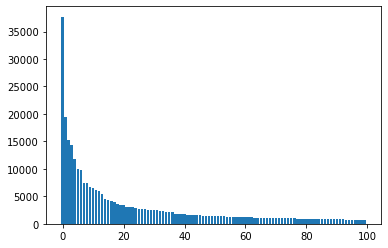

In [13]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

In [14]:
num_words_dict = 30000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]

In [15]:
# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}


# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
  word_to_idx[word] = num + 2
  idx_to_word[num+2] = word

In [16]:
# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
  sentences_idx = []
  for sent in sentences_tokens:
    sent_idx = []
    for word in sent:
      if word in word_to_idx:
        sent_idx.append(word_to_idx[word])
      else:
        sent_idx.append(word_to_idx['UNK'])
    sentences_idx.append(sent_idx)
  return sentences_idx

In [17]:
x_train_idx = tokens_to_idx(x_train_token,word_to_idx)
x_test_idx = tokens_to_idx(x_test_token,word_to_idx)

In [18]:
some_number = 1
print('Before converting: ', x_train_token[some_number])
print('After converting: ', x_train_idx[some_number])

Before converting:  ['--', 'omg', 'i', 'cannot', 'believe', 'jay', 'leno', 'is', 'going', 'off', 'the', 'air', 'i', 'hate', 'conan', '<-empu', 'o', "'", 'brian', '<-empu']
After converting:  [777, 254, 3, 63, 376, 1165, 1422, 10, 44, 101, 7, 871, 3, 172, 4805, 28, 678, 27, 2575, 28]


In [19]:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  84
Mean tweet word length:  15.0
99% percent under:  37.0


In [21]:
# We choose the max length
max_length = 87

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, tweet in enumerate(sentences):
        len_tweet = len(tweet) 
        if len_tweet != 0:
            if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
                features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
            if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
                features[ii, :] = np.array(tweet)[-seq_len:]
    return features

In [22]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [23]:
some_number = 3
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [4, 581, 10, 3, 20, 6, 48, 11, 187, 42, 150, 69, 145, 73, 229, 2]
After padding:  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   4
 581  10   3  20   6  48  11 187  42 150  69 145  73 229   2]


# Define dataloader and model

In [24]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last = True)

In [25]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('x size: ', sample_x.size(), 'Y size', sample_y.size()) # batch_size, seq_length
# print('Sample input: \n', sample_x)
# print('Sample output: \n', sample_y)

x size:  torch.Size([100, 87]) Y size torch.Size([100])


In [26]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim, drop_prob=0.55):
        super(SentimentRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.no_layers = no_layers

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM Layers
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=no_layers, 
                            batch_first=True, 
                            dropout=drop_prob,
                            bidirectional=True
                            )
                                  

        # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # Linear and Sigmoid layer
        # why not no_layers*hidden_dim? and for biLSTM x2?
        self.fc = nn.Linear(2*hidden_dim, output_dim)
#         self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Embedding out
        embeds = self.embedding(x)
        #Shape: [batch_size x max_length x embedding_dim]

        # LSTM out
        lstm_out, hidden = self.lstm(embeds, hidden)
        # Shape: [batch_size x max_length x hidden_dim]

        # Select the activation of the last Hidden Layer
        lstm_out = lstm_out[:,-1,:].contiguous()
        # Shape: [batch_size x hidden_dim]

         ## You can instead average the activations across all the times
        # lstm_out = torch.mean(lstm_out, 1).contiguous()

        # Dropout and Fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # Sigmoid function
#         sig_out = self.sig(out)

        # return last sigmoid output and hidden state
        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        #random initialization is better, i think 
        h0 = torch.randn((2*self.no_layers, batch_size, self.hidden_dim)).to(device)
        c0 = torch.randn((2*self.no_layers, batch_size, self.hidden_dim)).to(device)
        hidden = (h0, c0)
        return hidden


In [27]:
# Let's define our model
model = SentimentRNN(no_layers=3,
                     vocab_size=num_words_dict, # 43800 dictionary
                     hidden_dim=64,
                     embedding_dim=32,
                     output_dim=LEN_CLASSES,    # 13 classes
                     drop_prob=0.55
                    )


# Moving to gpu
model.to(device)
print(model)

SentimentRNN(
  (embedding): Embedding(30000, 32)
  (lstm): LSTM(32, 64, num_layers=3, batch_first=True, dropout=0.55, bidirectional=True)
  (dropout): Dropout(p=0.55, inplace=False)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)


In [28]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  1209993


In [29]:
# loss and optimization functions
lr = 0.0001

criterion = nn.CrossEntropyLoss().to(device)

# We choose an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred, labels):
    pred = torch.argmax(pred, dim=1)
#     labels = torch.argmax(labels, dim=1)
    return torch.sum((pred == labels).float())

In [33]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14943635588659700798
]


In [34]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
# Number of training Epochs
epochs = 50
# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

# Train for a number of Epochs
for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0
  model.train()

  for inputs, labels in train_loader:
    # Initialize hidden state 
    h = model.init_hidden(batch_size)
    
    # Creating new variables for the hidden state
    h = tuple([each.data.to(device) for each in h])
    
    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
    model.zero_grad()
    
    # Compute model output
    output, h = model(inputs, h)

    # Calculate the loss and perform backprop
    loss = criterion(output.squeeze(), labels.long())
    loss.backward()
    train_losses.append(loss.item())
    
    # calculating accuracy
    accuracy = acc(output,labels)
    train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    
  # Evaluate on the validation set for this epoch 
  val_losses = []
  val_acc = 0.0
  model.eval()
    
  for inputs, labels in test_loader:
    
    # Initialize hidden state 
    val_h = model.init_hidden(batch_size)
    val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output, val_h = model(inputs, val_h)

    # Compute Loss
    val_loss = criterion(output.squeeze(), labels.long())

    val_losses.append(val_loss.item())

    accuracy = acc(output, labels)
    val_acc += accuracy

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)
  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(test_loader.dataset)
  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)
  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)
  print(f'Epoch {epoch+1}') 
  print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
  print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
  if epoch_val_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
    valid_loss_min = epoch_val_loss
  print(25*'==')

Epoch 1
train_loss : 1.9165576454068793 val_loss : 1.9105507621639652
train_accuracy : 29.547542572021484 val_accuracy : 29.521310806274414
Validation loss decreased (inf --> 1.910551).  Saving model ...
Epoch 2
train_loss : 1.9075394341203034 val_loss : 1.8999784290790558
train_accuracy : 30.31803321838379 val_accuracy : 29.613113403320312
Validation loss decreased (1.910551 --> 1.899978).  Saving model ...
Epoch 3
train_loss : 1.9001301714631378 val_loss : 1.896467924118042
train_accuracy : 30.560653686523438 val_accuracy : 30.203279495239258
Validation loss decreased (1.899978 --> 1.896468).  Saving model ...
Epoch 4
train_loss : 1.8907057359570363 val_loss : 1.8926154218221967
train_accuracy : 31.275409698486328 val_accuracy : 30.465572357177734
Validation loss decreased (1.896468 --> 1.892615).  Saving model ...
Epoch 5
train_loss : 1.8822385995114437 val_loss : 1.8865747216500734
train_accuracy : 31.413114547729492 val_accuracy : 31.200000762939453
Validation loss decreased (1.89

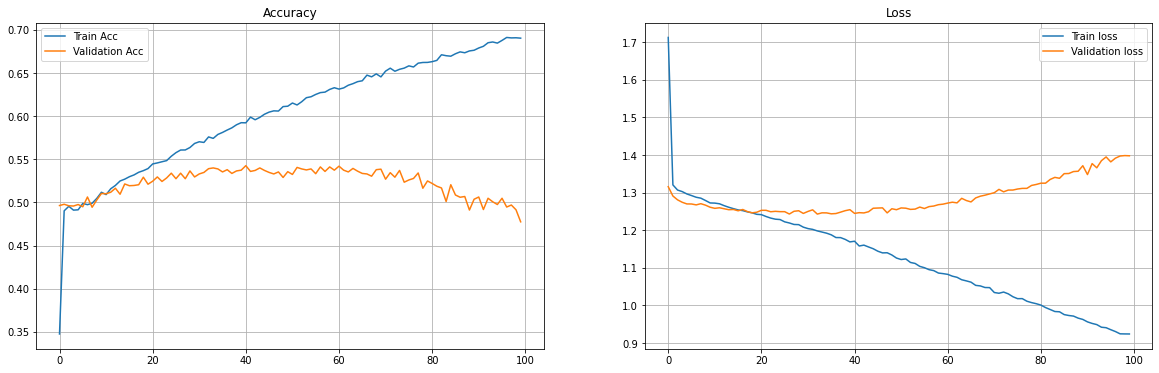

In [30]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()